In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import shap

In [3]:
#loading the stopwords library and the nltk to be used for the text preprocessing
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/eosamau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eosamau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
train_data = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')
test_data = pd.read_csv('drugsComTest_raw.tsv', sep='\t')
train_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [5]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re



def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens) #--- Joins the token into a simple word. 

train_data['processed_review'] = train_data['review'].apply(preprocess_text)
test_data['processed_review'] = test_data['review'].apply(preprocess_text)
train_data['processed_review'].head()

0           side effect take combin bystol mg fish oil
1    son halfway fourth week intuniv becam concern ...
2    use take anoth oral contracept pill cycl happi...
3    first time use form birth control im glad went...
4    suboxon complet turn life around feel healthie...
Name: processed_review, dtype: object

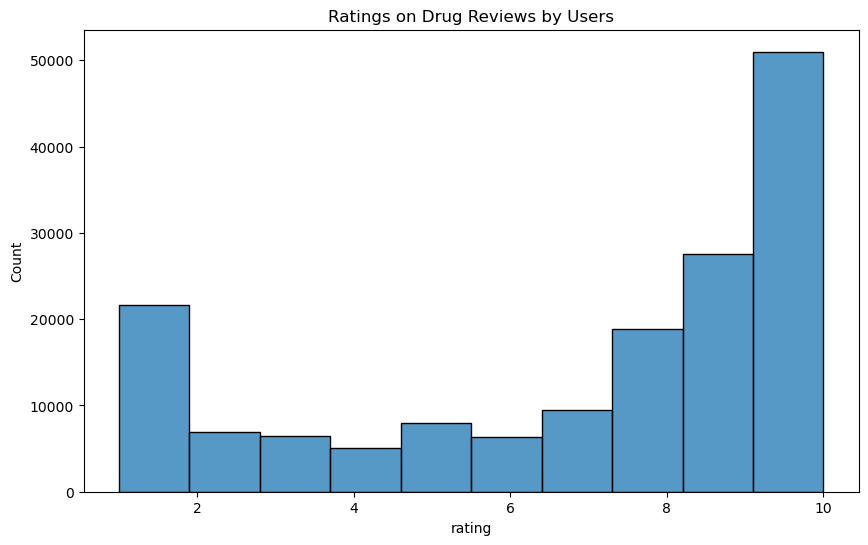

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['rating'], bins=10)
plt.title('Ratings on Drug Reviews by Users')
plt.savefig('histogram_of_ratings.png')
plt.show()

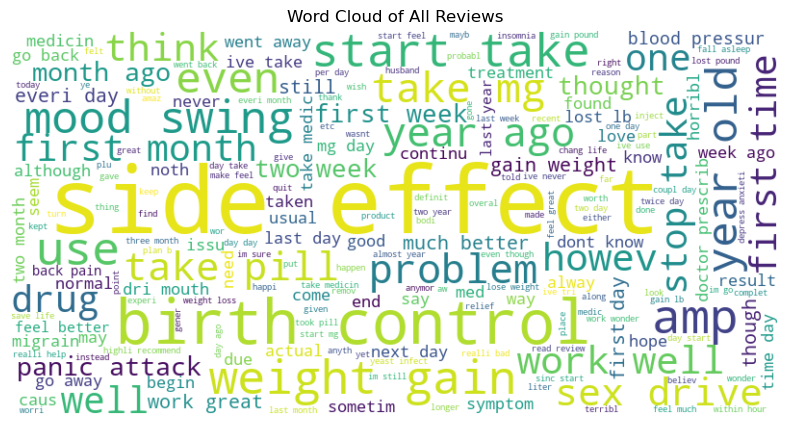

In [7]:
#creating a word cloud to visualize the most used words in 215,063 drug reviews by the users
from wordcloud import WordCloud

all_words = ' '.join(train_data['processed_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.title('Word Cloud of All Reviews')

plt.savefig('wordcloud.png')
plt.show()

In [8]:
#---------TF-IDF -----------#

#Now in this stage we want to assign importance to words in the training data by using the TF IDF method which 
#can help distinguish words in accordance to how they are most used for ratings

#tfidf = TfidfVectorizer(max_features=5000)
#X_tfidf = tfidf.fit_transform(train_data['processed_review'])
#y = train_data['rating']
#X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)



## Text Processing and Feature Engineering

In [9]:
import gensim



# Training a Word2Vec model tokenized reviews using the SkipGram method
word2vec_model = gensim.models.Word2Vec(sentences=train_data['processed_review'], vector_size=300, window=5, min_count=2, sg=1, workers=4)


def get_average_word2vec(tokens_list, model, vector_size):
    
    valid_words = [word for word in tokens_list if word in model.wv.key_to_index] #vocabulary from word2Vec model
    
    if not valid_words: 
        return np.zeros(vector_size) #we want to return a zero vector for the doc in case no valid words are found in the doc
    
    return np.mean(model.wv[valid_words], axis=0) # the entire review is converted into a single vector, 
                                                  #instead of different vectors for each word in the document

vector_size = word2vec_model.vector_size
train_data['word2vec_review'] = train_data['processed_review'].apply(lambda x: get_average_word2vec(x, word2vec_model, vector_size))


X_word2vec = np.vstack(train_data['word2vec_review'].values) # To convert the into a numpy array

y = train_data['rating']

X_train_w2v, X_val_w2v, y_train, y_val = train_test_split(X_word2vec, y, test_size=0.2, random_state= 16 )



In [10]:
X_train_w2v.shape #This Word2Vec now has an array of 129037 docs with 300 features from the the word2Vec model 

(129037, 300)

In [11]:
train_data['rating'].value_counts()

rating
10.0    50989
9.0     27531
1.0     21619
8.0     18890
7.0      9456
5.0      8013
2.0      6931
3.0      6513
6.0      6343
4.0      5012
Name: count, dtype: int64

In [12]:
#Reviewing the target feature again this may not necessarily be a regression problem 
#But we can consider it as an ordinal classification problem, and therefore we need to use binary encoding for the 
#Target variable

from sklearn.preprocessing import OrdinalEncoder

y_train_array = np.array(y_train).reshape(-1, 1)
y_val_array = np.array(y_val).reshape(-1, 1)

encoder = OrdinalEncoder()

y_train_encoded = encoder.fit_transform(y_train_array).flatten()
y_val_encoded = encoder.transform(y_val_array).flatten()


In [13]:
y_train_encoded

array([7., 0., 9., ..., 6., 1., 6.])

## Model Building

In [14]:
#Setting up the model for classification
n_classes = len(encoder.categories_[0])

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input


model = Sequential([
    Input(shape=(X_train_w2v.shape[1],)), 
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(n_classes - 1, activation='sigmoid')  # because a binary ordinal encoder is used on the targets
])

#### Customizing the loss function to account for the ordinal nature of the target variable

In [15]:
import tensorflow as tf

# Because we want the loss function to account for the order of the targets in classification
# this loss function is used, it compares the pred and ground truth variables but considers the cum sums of the 
# ground truth and pred, if they are as the same level them it is true positive, if one is greater or lesser
# than the other then it will be a false positive or false negative
def ordinal_loss(y_true, y_pred):
    difference = tf.math.squared_difference(
        tf.math.cumsum(y_true, axis=1),
        tf.math.cumsum(y_pred, axis=1)
    )
    return tf.reduce_mean(difference)

#### Compiling the model

In [16]:
#Starting with the Adam Optimizer (Mainly due to its adaptive learning in the loss landscape)
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0005), loss=ordinal_loss, metrics=['accuracy'])


In [17]:
# we're respecting the order of the classes
# For example, predicting a rating of 8 when the ground truth is 9 is a smaller error than predicting a rating of 2
# we then create a binary indicator: "Is the rating greater than or equal to this value? eg. for a class [1, 1, 1, 1, 1, 1, 0, 0, 0]

def to_binary(y, n_classes):
    return np.greater_equal.outer(y, np.arange(1, n_classes)).astype(int) #checks if it is greater compared to the list and returns 1 or 0

y_train_binary = to_binary(y_train_encoded, n_classes) 
y_val_binary = to_binary(y_val_encoded, n_classes)

#### Training 1

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_w2v, y_train_binary, epochs=50, batch_size=32, 
                    validation_data=(X_val_w2v, y_val_binary), verbose=1, callbacks=[early_stopping])

#Validation data in there, helps to evaluate the model performance after each epoch



Epoch 1/50
4033/4033 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.0035 - loss: 4.5078 - val_accuracy: 0.0000e+00 - val_loss: 4.2608
Epoch 2/50
4033/4033 ━━━━━━━━━━━━━━━━━━━━ 4s 958us/step - accuracy: 2.0195e-05 - loss: 4.3414 - val_accuracy: 0.0000e+00 - val_loss: 4.2154
Epoch 3/50
4033/4033 ━━━━━━━━━━━━━━━━━━━━ 4s 962us/step - accuracy: 9.7315e-06 - loss: 4.3080 - val_accuracy: 0.0000e+00 - val_loss: 4.2108
Epoch 4/50
4033/4033 ━━━━━━━━━━━━━━━━━━━━ 4s 955us/step - accuracy: 3.5198e-05 - loss: 4.2653 - val_accuracy: 6.1996e-05 - val_loss: 4.2472
Epoch 5/50
4033/4033 ━━━━━━━━━━━━━━━━━━━━ 4s 955us/step - accuracy: 1.2898e-04 - loss: 4.2921 - val_accuracy: 6.1996e-05 - val_loss: 4.1913
Epoch 6/50
4033/4033 ━━━━━━━━━━━━━━━━━━━━ 4s 955us/step - accuracy: 1.9077e-04 - loss: 4.3063 - val_accuracy: 9.2994e-05 - val_loss: 4.1841
Epoch 7/50
4033/4033 ━━━━━━━━━━━━━━━━━━━━ 4s 948us/step - accuracy: 9.5053e-05 - loss: 4.2501 - val_accuracy: 6.1996e-05 - val_loss: 4.1822
Epoch 8/50
4033/4033 ━━━━━

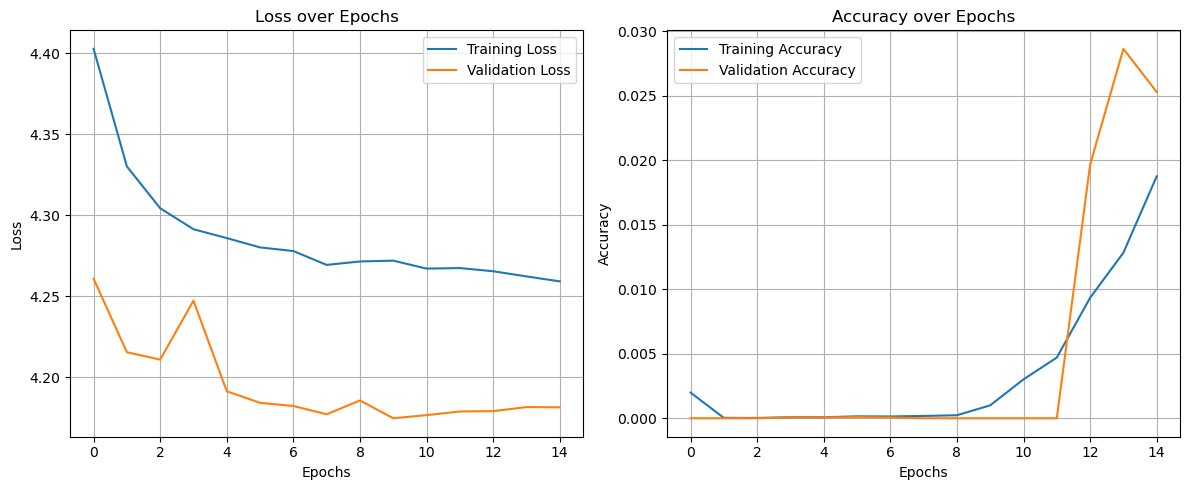

In [19]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Both training and validation decreasing over time shows the model is learning. Validation accuracy of the model is more volatile even though it increases over the epochs.

In [20]:
def predict_rating(review_vector):
    pred = model.predict(review_vector.reshape(1, -1))[0]
    predicted_class = np.sum(pred >= 0.5)
    predicted_class = np.clip(predicted_class, 0, n_classes - 1)  # Ensure it's within valid range
    return encoder.inverse_transform([[predicted_class]])[0][0]




In [24]:
# Evaluate the model
y_val_pred = np.array([predict_rating(x) for x in X_val_w2v[:100]])
accuracy = np.mean(y_val_pred == y_val[:100])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

In [26]:
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.1200


### Training 2